In [2]:
# calling basic imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Plotting library
from matplotlib import pyplot as plt
import seaborn as sns

# Additional support libraries
import os

# Library for reading images 
from PIL import Image

# Random
import random
from tqdm import tqdm_notebook


In [3]:
train  = pd.read_csv('train_relationships.csv')
train.tail()

,p1,p2
3593,F1000/MID5,F1000/MID8
3594,F1000/MID5,F1000/MID9
3595,F1000/MID6,F1000/MID9
3596,F1000/MID7,F1000/MID8
3597,F1000/MID7,F1000/MID9


In [4]:
TRAIN_BASE = 'train/'
families = sorted(os.listdir(TRAIN_BASE))
print('We have {} families in the dataset'.format(len(families)))
print(families[:5])

We have 470 families in the dataset
['F0002', 'F0005', 'F0009', 'F0010', 'F0016']


In [5]:
members = {i:sorted(os.listdir(TRAIN_BASE+i)) for i in families}

In [6]:
TEST_BASE='test/'
test_images_names = os.listdir(TEST_BASE)
test_images_names[:5]

['face04028.jpg',
 'face05612.jpg',
 'face01832.jpg',
 'face01672.jpg',
 'face05546.jpg']

In [7]:
def load_img(PATH): return np.array(Image.open(PATH))

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def plot_relations(df, BASE='train/', rows=1, titles=None):
    tdf = df[:rows]
    tdf1 = tdf.p1
    tdf2 = tdf.p2
    figsize=(5,3*rows)
    f = plt.figure(figsize=figsize)
    x = 0
    for i in range(rows):
        sp = f.add_subplot(rows, 2, x+1)
        sp.axis('Off')
        x+=1
        image_path = os.path.join(BASE,tdf1[i])
        im = os.listdir(image_path)[-1]
        sp.set_title(tdf1[i], fontsize=16)
        plt.imshow(load_img(os.path.join(image_path, im)))
        sp = f.add_subplot(rows, 2, x+1)
        x+=1
        sp.axis('Off')
        image_path = os.path.join(BASE,tdf2[i])
        im = os.listdir(image_path)[-1]
        sp.set_title(tdf2[i], fontsize=16)
        plt.imshow(load_img(os.path.join(image_path, im)))

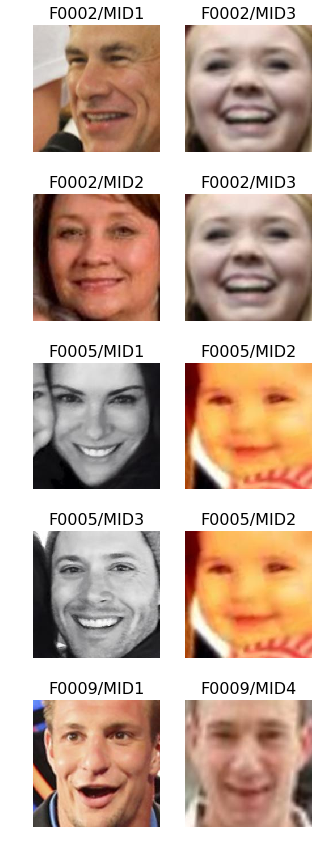

In [8]:
plot_relations(train, rows=5)

In [8]:
test_images=np.array([load_img(os.path.join(TEST_BASE,image)) for image in test_images_names])
test_images.shape

(6282, 224, 224, 3)

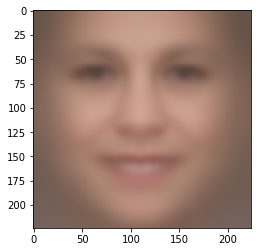

In [9]:
plt.imshow(test_images.sum(axis=0)//test_images.shape[0])

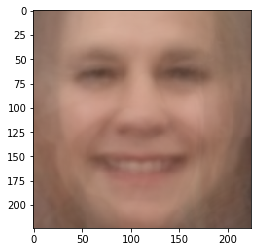

In [10]:
avg_face = []
u=0
for family in families[u:u+1]:
    for member in os.listdir(os.path.join(TRAIN_BASE,family)):
        for image in os.listdir(os.path.join(TRAIN_BASE, family, member)):
            avg_face.append(load_img(os.path.join(TRAIN_BASE, family, member, image)))
avg_face=np.array(avg_face)
plt.imshow(avg_face.sum(axis=0)//avg_face.shape[0])

In [9]:
!pip install tensorflow keras
import keras
from keras.models import Model
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dropout, Activation

from keras import backend as K
K.set_image_data_format('channels_first')

Using TensorFlow backend.


In [10]:
def vgg_face(weights_path=None):
    img = Input(shape=(3, 224, 224))

    pad1_1 = ZeroPadding2D(padding=(1, 1))(img)
    conv1_1 = Convolution2D(64, (3, 3), activation='relu', name='conv1_1')(pad1_1)
    pad1_2 = ZeroPadding2D(padding=(1, 1))(conv1_1)
    conv1_2 = Convolution2D(64, (3, 3), activation='relu', name='conv1_2')(pad1_2)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1_2)

    pad2_1 = ZeroPadding2D((1, 1))(pool1)
    conv2_1 = Convolution2D(128, (3, 3), activation='relu', name='conv2_1')(pad2_1)
    pad2_2 = ZeroPadding2D((1, 1))(conv2_1)
    conv2_2 = Convolution2D(128, (3, 3), activation='relu', name='conv2_2')(pad2_2)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2_2)

    pad3_1 = ZeroPadding2D((1, 1))(pool2)
    conv3_1 = Convolution2D(256, (3, 3), activation='relu', name='conv3_1')(pad3_1)
    pad3_2 = ZeroPadding2D((1, 1))(conv3_1)
    conv3_2 = Convolution2D(256, (3, 3), activation='relu', name='conv3_2')(pad3_2)
    pad3_3 = ZeroPadding2D((1, 1))(conv3_2)
    conv3_3 = Convolution2D(256, (3, 3), activation='relu', name='conv3_3')(pad3_3)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3_3)

    pad4_1 = ZeroPadding2D((1, 1))(pool3)
    conv4_1 = Convolution2D(512, (3, 3), activation='relu', name='conv4_1')(pad4_1)
    pad4_2 = ZeroPadding2D((1, 1))(conv4_1)
    conv4_2 = Convolution2D(512, (3, 3), activation='relu', name='conv4_2')(pad4_2)
    pad4_3 = ZeroPadding2D((1, 1))(conv4_2)
    conv4_3 = Convolution2D(512, (3, 3), activation='relu', name='conv4_3')(pad4_3)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2))(conv4_3)

    pad5_1 = ZeroPadding2D((1, 1))(pool4)
    conv5_1 = Convolution2D(512, (3, 3), activation='relu', name='conv5_1')(pad5_1)
    pad5_2 = ZeroPadding2D((1, 1))(conv5_1)
    conv5_2 = Convolution2D(512, (3, 3), activation='relu', name='conv5_2')(pad5_2)
    pad5_3 = ZeroPadding2D((1, 1))(conv5_2)
    conv5_3 = Convolution2D(512, (3, 3), activation='relu', name='conv5_3')(pad5_3)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2))(conv5_3)

    fc6 = Convolution2D(4096, (7, 7), activation='relu', name='fc6')(pool5)
    fc6_drop = Dropout(rate = 0.5)(fc6)
    fc7 = Convolution2D(4096,( 1, 1), activation='relu', name='fc7')(fc6_drop)
    fc7_drop = Dropout(rate = 0.5)(fc7)
    fc8 = Convolution2D(2622, (1, 1), name='fc8')(fc7_drop)
    flat = Flatten()(fc8)
    out = Activation('softmax')(flat)

    model = Model(inputs=img, outputs=out)

    if weights_path:
        model.load_weights(weights_path)

    return model

In [16]:
import h5py    
import numpy as np    
#f1 = h5py.File('vgg-face-keras.h5','r+')
vgg_facenet = vgg_face('vgg_face_weights.h5')

In [1]:
vgg_facenet.summary()

NameError: name 'vgg_facenet' is not defined

In [70]:
im = Image.open('train/F0002/MID1/P00009_face3.jpg')
im = np.array(im).astype(np.float32)
im2 = Image.open('train/F0002/MID3/P00014_face1.jpg')
im2 = np.array(im2).astype(np.float32)
im = im.transpose((2,0,1))
im = np.expand_dims(im, axis=0)
im2 = im2.transpose((2,0,1))
im2 = np.expand_dims(im2, axis=0)
np.concatenate([im,im2]).shape

(2, 3, 224, 224)

In [96]:
out = vgg_facenet.predict(np.concatenate([im,im2]))
def cosine_similarity(a,b):
    return np.sum(np.multiply(a,b))/np.multiply( np.sqrt(np.sum(np.power(a,2))),(np.sqrt(np.sum(np.power(b,2)))))

def distance(x, y):
    return np.linalg.norm(x - y)
print(cosine_similarity(out[0], out[1]), distance(out[0], out[1]))

0.27292714 0.29671738


In [125]:
test_images = os.listdir(TEST_BASE)
test = np.array([load_img(os.path.join(TEST_BASE, i)) for i in test_images])
test_emb = vgg_facenet.predict(test.transpose(0,3,1,2))
print(test.shape, test_emb.shape)

(201, 224, 224, 3) (201, 2622)


In [119]:
image_mapping = {img:idx for idx, img in enumerate(test_images)}

submission = pd.read_csv('sample_submission.csv')
req_mapping = [i.split('-') for i in submission.img_pair]
vector_distances=[]
for i in req_mapping:
    a = i[0]
    b = i[1]
    dis = distance(test_emb[image_mapping[a]], test_emb[image_mapping[b]])
    vector_distances.append(dis)
vector_distances=np.array(vector_distances)
total_sum = vector_distances.sum()

In [120]:
probs = []
for dist in vector_distances:
    prob = np.sum(vector_distances[np.where(vector_distances <= dist)[0]])/total_sum
    probs.append(1 - prob)
vector_distances.shape

(11,)

In [121]:
np.sum(vector_distances[np.where(vector_distances <= dist)[0]])/total_sum

0.22320747

In [122]:
submission.is_related = probs

In [123]:
submission.to_csv('submission.csv', index=False)

In [124]:
submission.head()

,img_pair,is_related
0,face00108.jpg-face00120.jpg,0.302583
1,face00050.jpg-face00098.jpg,0.442526
2,face00020.jpg-face00038.jpg,0.622880
3,face00004.jpg-face00072.jpg,0.702782
4,face00028.jpg-face00011.jpg,0.958667


In [ ]:
face00011